# part0: imports

In [34]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator

from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

# Global params
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'PMd')

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_target_on', 
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )

preprocessing

In [2]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [3]:
def prep_general (df):
    "preprocessing general!"
    time_signals = [signal for signal in pyal.get_time_varying_fields(df) if 'spikes' in signal]
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    for signal in time_signals:
        df_ = pyal.remove_low_firing_neurons(df, signal, 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in time_signals:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_


%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


In [38]:
def custom_r2_func(y_true, y_pred):
    "$R^2$ value as squared correlation coefficient, as per Gallego, NN 2020"
    return stats.pearsonr(y_true, y_pred)[0] **2

custom_r2_scorer = make_scorer(custom_r2_func)

# Decoding

Decode the arm velocity from M1 activity.

## idea

train the decoder on monkey1 and decode the behaviour of monkey2

>**correction**: the idea is to decode kinematics from the aligned dynamics of 2 monkeys.

### run a test decoder

In [4]:
fname = root / 'Chewie' / "Chewie_CO_CS_2016-10-21.mat"
df = dt.load_pyal_data(fname)
df = prep_general(df)
df_ = pyal.restrict_to_interval(df, epoch_fun=exec_epoch)
model = PCA(10).fit(pyal.concat_trials(df_, 'M1_rates'))
df_ = pyal.apply_dim_reduce_model(df_, model, 'M1_rates', 'M1_pca')

/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [5]:
Y1, Y2 = pyal.concat_trials(df_, 'vel').T

X_no_hist = pyal.concat_trials(df_, 'M1_pca')
print(f'{X_no_hist.shape=}')

X_no_hist.shape=(4290, 10)


In [6]:
X_hist = []
for i in range(4):
    _epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE)-i,
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)-i
                                    )
    _df = pyal.restrict_to_interval(df, epoch_fun=_epoch)
    _model = PCA(n_components).fit(pyal.concat_trials(_df, 'M1_rates'))
    _df = pyal.apply_dim_reduce_model(_df, _model, 'M1_rates', '_pca')
    X_hist.append(pyal.concat_trials(_df, '_pca'))

X = np.concatenate ((*X_hist,), axis=1)

In [7]:
reg = LinearRegression()
reg.fit(X, Y1)
reg.score(X, Y1)

0.8908431213123226

---

**across monkey decoding**

In [4]:
def get_data_array_and_vel(data_list: list[pd.DataFrame], epoch , area: str ='M1', n_components: int =10) -> np.ndarray:
    """
    Applies PCA to the data and return a data matrix of the shape: sessions x targets x  trials x time x PCs
    with the minimum number of trials and timepoints shared across all the datasets/targets.
    
    Parameters
    ----------
    `data_list`: list of pd.dataFrame datasets from pyal-data
    `epoch`: an epoch function of the type `pyal.generate_epoch_fun`
    `area`: area, either: 'M1', or 'S1', or 'PMd'

    Returns
    -------
    `AllData`: np.array

    Signature
    -------
    AllData = get_data_array(data_list, execution_epoch, area='M1', n_components=10)
    all_data = np.reshape(AllData, (-1,10))
    """
    field = f'{area}_rates'
    n_shared_trial = np.inf
    for df in data_list:
        for target in range(8):
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    df_ = pyal.restrict_to_interval(df_,epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), 8, n_shared_trial, n_timepoints, n_components))
    AllVel  = np.empty((len(data_list), 8, n_shared_trial, n_timepoints, 2))
    rng = np.random.default_rng(12345)
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
        rates = np.concatenate(df_[field].values, axis=0)
        rates -= np.mean(rates, axis=0)
        rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

        for target in range(8):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            rng.shuffle(all_id)
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, (trial_rates,trial_vel) in enumerate(zip(df__._pca, df__.vel)):
                AllData[session,target,trial, :, :] = trial_rates
                AllVel[session,target,trial, :, :] = trial_vel
    
    return AllData, AllVel

# Within animal decoding

select sessions of the same animal $A$ and $B$ to compute the the canonical axes, and then decode kinematics. One decoder per pair of sessions, similar to the NN paper.

decoder performance cross-validated on the second day in each pair

In [5]:
full_list = []
for area in ('dualArea','M1'):
    for animal, sessionList in GoodDataList[area].items():
#         if '2' in animal:
#             continue  # to remove Chewie2
        full_list.append((animal,sessionList))

full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

# load the DFs
warnings.filterwarnings("ignore")
allDFs = []
for animal, session in full_list:
    path = root/animal/session
    allDFs.append(prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")

In [30]:
# pairIndexList = list[ tuple[train1, list[test]]]
pairIndexList = []
for i, (animal1,session1) in enumerate(full_list):
    pairIndexList.append((i,[]))
    for j, (animal2,session2) in enumerate(full_list):
        if animal1 != animal2: continue
        if session1 == session2: continue
        pairIndexList[-1][1].append(j)

In [ ]:
MAX_HISTORY = 3  #int: no of bins

reg_scores = []
for id1, testList in pairIndexList:
    for testId in testList:
        AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)
        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel2 = AllVel[1,...]
        # resizing
        AllData1 = AllData1.reshape((-1,n_components))
        AllData2 = AllData2.reshape((-1,n_components))
        min_time = min([AllData1.shape[-2],AllData2.shape[-2]])
        # adding history
        X1_hist = []
        X2_hist = []
        for shift in range(MAX_HISTORY+1):
            X1_hist.append(np.roll(AllData1, shift, axis=0))
            X2_hist.append(np.roll(AllData2, shift, axis=0))
        X1 = np.concatenate((*X1_hist,), axis=1)
        X2 = np.concatenate((*X2_hist,), axis=1)
        # controlling the size
        AllVel2 = AllVel2.reshape((-1,2))[MAX_HISTORY:min_time,:]
        X1 = X1[MAX_HISTORY:min_time,:]  # removing the leading zeros
        X2 = X2[MAX_HISTORY:min_time,:]
    
        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        Y_x,Y_y = AllVel2.T
        # train the decoder
        x_score = cross_val_score(LinearRegression(), V, Y_x, cv=5, scoring = custom_r2_scorer)
        y_score = cross_val_score(LinearRegression(), V, Y_y, cv= 5, scoring = custom_r2_scorer)
        reg_scores.append((id1,testId,(x_score.mean(),y_score.mean())))

pop_score = []
for _,_,scores in reg_scores:
    pop_score.append(np.add(*scores)/2)
pop_score = np.array(pop_score)

In [18]:
from sklearn.metrics import make_scorer, r2_score

default_scorer = make_scorer(r2_score, multioutput='variance_weighted')

120


(0.0, 1.0)

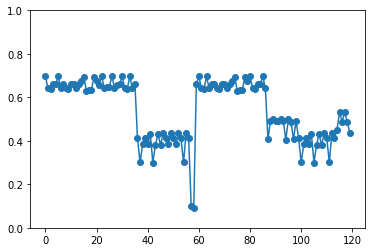

In [40]:
print(pop_score.size)
plt.plot(pop_score,'-o')
plt.ylim([0,1])

# Old

single decoder all the pairs

In [ ]:
# pairIndexList = list[ tuple[(train1, train2, list[test])], ]
pairIndexList = []
for i, session1 in enumerate(full_list):
    animal1 = session1.split('_')[0]
    for j, session2 in enumerate(full_list):
        animal2 = session2.split('_')[0]
        if animal1 != animal2: continue
        pairIndexList.append((i,j,[k for k, session3 in enumerate(full_list) if session3 not in session1+session2 and
                                                                                session3.split('_')[0] in animal1+animal2 ]))

In [28]:
MAX_HISTORY = 3  #int: no of bins

reg_objs = []
# reg_scores = list[ tuple[train1, train2, list[tuple[test_x,test_y]]]]
reg_scores = []
for id1, id2, testList in pairIndexList:
    AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[id2]], exec_epoch, area=areas[0], n_components=n_components)
    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel2 = AllVel[1,...]
    # resizing
    AllData1 = AllData1.reshape((-1,n_components))
    AllData2 = AllData2.reshape((-1,n_components))
    min_time = min([AllData1.shape[-2],AllData2.shape[-2]])
    # adding history
    X1_hist = []
    X2_hist = []
    for shift in range(MAX_HISTORY+1):
        X1_hist.append(np.roll(AllData1, shift, axis=0))
        X2_hist.append(np.roll(AllData2, shift, axis=0))
    X1 = np.concatenate((*X1_hist,), axis=1)
    X2 = np.concatenate((*X2_hist,), axis=1)
    # controlling the size
    AllVel2 = AllVel2.reshape((-1,2))[MAX_HISTORY:min_time,:]
    X1 = X1[MAX_HISTORY:min_time,:]  # removing the leading zeros
    X2 = X2[MAX_HISTORY:min_time,:]
    
    A,B,*_ = dt.canoncorr(X1, X2, fullReturn=True)
    Y_x,Y_y = AllVel2.T
    # train the decoder
    reg_x = LinearRegression()
    reg_y = LinearRegression()
    reg_x.fit(X2@B, Y_x)
    reg_y.fit(X2@B, Y_y)
    reg_objs.append((reg_x,reg_y))
    reg_scores.append((id1,id2,[]))
    # test the decoding on unrelated sessions
    for testId in testList:
        AllDataTest, AllVelTest = get_data_array_and_vel([allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)
        # resizing
        AllDataTest = AllDataTest.reshape((-1,n_components))
        # adding history
        X_test_hist = []
        for shift in range(MAX_HISTORY+1):
            X_test_hist.append(np.roll(AllDataTest, shift, axis=0))
        X_test = np.concatenate((*X_test_hist,), axis=1)
        # controlling the size
        AllVelTest = AllVelTest.reshape((-1,2))[MAX_HISTORY:,:]
        X_test = X_test[MAX_HISTORY:,:]  # removing the leading zeros
        min_timebins = min([X_test.shape[0],X1.shape[0]])
        
        A,B,*_ = dt.canoncorr(X1[:min_timebins,:], X_test[:min_timebins,:], fullReturn=True)
        Y_test_x,Y_test_y = AllVelTest[:min_timebins,:].T
        U_test = X_test[:min_timebins,:] @ B
        # test the decoder
        reg_scores[-1][2].append((reg_x.score(U_test, Y_test_x),
                                  reg_y.score(U_test, Y_test_y)
                                 )
                                )
pop_score = []
for _,_,scores in reg_scores:
    for x_score,y_score in scores:
        pop_score.append((x_score+y_score)/2)
pop_score = np.array(pop_score)

130


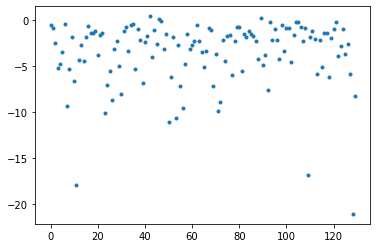

In [32]:
print(pop_score.size)
plt.plot(pop_score,'.')
# plt.ylim([0,1])